In [1]:
%pylab inline
from mpl_toolkits.mplot3d import Axes3D
import emcee
import corner
import timeit

Populating the interactive namespace from numpy and matplotlib


In [2]:
Fo = 2 * 10 ** 9 # 2 GHz, GPS Frequency
c  = 3 * 10 ** 5 # Km/s

# Ground Stations

First we define the position of the ground stations in the flat Earth model.

In [3]:
BaseA = np.array([ 200, -10, 0])
BaseB = np.array([ 100, 100, 0])
BaseC = np.array([  50,-150, 0])
BaseD = np.array([-100,  0, 1])

# The Satellite Class

In the flat Earth model satellites will have a straight line as their path, moving 
with constant speed.

In [4]:
class Satellite():
    def __init__(self, X0, Y0, Z0, Vx0, Vy0, Vz0):
        self.x0  = X0
        self.y0  = Y0
        self.z0  = Z0
        self.vx0 = Vx0
        self.vy0 = Vy0
        self.vz0 = Vz0
    
    def position(self, t):
        self.x = self.x0 + self.vx0 * t
        self.y = self.y0 + self.vy0 * t
        self.z = self.z0 + self.vz0 * t
        r = np.array([self.x, self.y, self.z])
        return r
    
    def velocity(self, t):
        self.vx = self.vx0 + 0 * t
        self.vy = self.vy0 + 0 * t
        self.vz = self.vz0 + 0 * t
        v = np.array([self.vx, self.vy, self.vz])
        return v
        
    def rel_vel_to_base(self, t, Base):
        """
        Returns the relative speed of the satellite to
        some ground location. This velocity is 
        positive if the satellite is going towards
        the ground location, negative if is going 
        outwards.
        """
        
        r = self.position(t)
        v = self.velocity(t)
        
        x1 = Base[0]
        y1 = Base[1]
        z1 = Base[2]
    
        x_r = r[0] - x1
        y_r = r[1] - y1
        z_r = r[2] - z1  

        d = ( x_r ** 2 + y_r ** 2 + z_r ** 2 )**0.5
    
        ux  = x_r / d
        uy  = y_r / d
        uz  = z_r / d
    
        u = np.array([ux, uy, uz])
        
        return np.inner(-u,v)

# Generate the Observations

I create a satellite named "A" with an initial position and 
a velocity.

Using this parameters, the singnal received by ground stations can
be modelled.

In [5]:
A = Satellite(-1000, 0, 400, 10, 0, -0.5 )

In [6]:
T = np.linspace(0,200, 10)

In [7]:
v_rel_A = []
v_rel_B = []
v_rel_C = []
v_rel_D = []


for t in T:
    v_rel_A.append(A.rel_vel_to_base(t, BaseA))
    v_rel_B.append(A.rel_vel_to_base(t, BaseB))
    v_rel_C.append(A.rel_vel_to_base(t, BaseC))
    v_rel_D.append(A.rel_vel_to_base(t, BaseD))


v_rel_A  = np.array(v_rel_A)    
v_rel_B  = np.array(v_rel_B)    
v_rel_C  = np.array(v_rel_C)    
v_rel_D  = np.array(v_rel_D)    



V_rel_True = np.hstack((v_rel_A, v_rel_B, v_rel_C, v_rel_D))

# Shift Frequencies
F_A = Fo * (1 + (v_rel_A / c) )
F_B = Fo * (1 + (v_rel_B / c) )
F_C = Fo * (1 + (v_rel_C / c) )
F_D = Fo * (1 + (v_rel_D / c) )


This is an array of the true relative speed of the Satellite to the Ground Stations.

In [8]:
V_rel_True

array([ 9.64464547,  9.47638803,  9.16723639,  8.52266642,  6.95977558,
        2.98174093, -3.2484085 , -7.0725741 , -8.56666645, -9.18710082,
        9.53407314,  9.2951276 ,  8.83709905,  7.83616733,  5.38022249,
        0.17030231, -5.17112235, -7.75192217, -8.80094353, -9.2773208 ,
        9.43913536,  9.14141111,  8.56196143,  7.28632236,  4.27777154,
       -1.15306967, -5.76599976, -7.91992105, -8.84116906, -9.28065417,
        9.34452644,  8.92754281,  8.0245512 ,  5.80069095,  0.81298228,
       -4.81070627, -7.63080124, -8.75989539, -9.2623105 , -9.51871126])

With a defined orbit, we can model the measured Doppler shift by the Ground Stations.

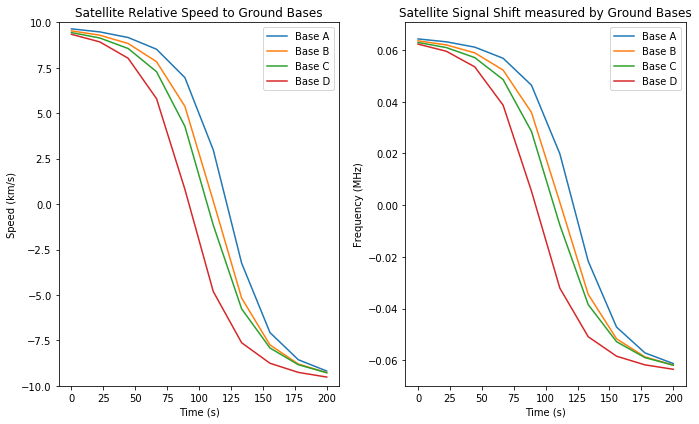

In [9]:
fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_subplot(121)
ax1.set_title("Satellite Relative Speed to Ground Bases")
ax1.set_ylabel("Speed (km/s)")
ax1.set_xlabel("Time (s)")

ax1.plot(T, v_rel_A, label="Base A")
ax1.plot(T, v_rel_B, label="Base B")
ax1.plot(T, v_rel_C, label="Base C")
ax1.plot(T, v_rel_D, label="Base D")

ax1.set_ylim(-10,10)
ax1.legend(loc=0)


#fig = plt.figure(figsize=(10,6))
ax2 = fig.add_subplot(122)
ax2.set_title("Satellite Signal Shift measured by Ground Bases")
ax2.set_ylabel("Frequency (MHz)")
ax2.set_xlabel("Time (s)")

ax2.plot(T, (F_A - Fo)/10**6, label="Base A")
ax2.plot(T, (F_B - Fo)/10**6, label="Base B")
ax2.plot(T, (F_C - Fo)/10**6, label="Base C")
ax2.plot(T, (F_D - Fo)/10**6, label="Base D")

#ax2.set_ylim(-0.1, +0.1)
ax2.legend(loc=0)


plt.tight_layout()

# Now a Monte Carlo!

The previous graph is taken as the measured data. Now we do the reverse process, finding the orbital elements from the measured data.

The MonteCarlo generates a satellite with a random set of orbital elements.

Then, it calculates which should be the measured data from this random satellite.

The likelihood is calculated as how close are these random measurements to the real measurements. 

In [10]:
def log_likelihood(theta):
    x, y, z, Vx, Vy, Vz = theta
     # Create a Satellite with Random Path
        
    if z < 300:
        return -numpy.inf
    
    MCsat = Satellite(x, y, z, Vx, Vy, Vz)
    
    # Create a sample of measurements from the 3 Bases
    MCsatV_rel_A = []
    MCsatV_rel_B = []
    MCsatV_rel_C = []
    MCsatV_rel_D = []

    for t in T:
        MCsatV_rel_A.append(MCsat.rel_vel_to_base(t, BaseA))
        MCsatV_rel_B.append(MCsat.rel_vel_to_base(t, BaseB))
        MCsatV_rel_C.append(MCsat.rel_vel_to_base(t, BaseC))
        MCsatV_rel_D.append(MCsat.rel_vel_to_base(t, BaseD))

    MCsatV_rel_A  = np.array(MCsatV_rel_A)    
    MCsatV_rel_B  = np.array(MCsatV_rel_B)    
    MCsatV_rel_C  = np.array(MCsatV_rel_C)    
    MCsatV_rel_D  = np.array(MCsatV_rel_D)    
    
    
    
    MC_V_rel = np.hstack((MCsatV_rel_A, MCsatV_rel_B, MCsatV_rel_C, MCsatV_rel_D))    
    
    chi2 = 0
    wds  = log(2*pi)
    for i in range(3 * len(T)):
        chi2 += (MC_V_rel[i] - V_rel_True[i])**2 + wds
        #print("{}\t{}\t{}".format(MC_V_rel[i],V_rel_True[i], chi2))
        
    return -0.5 * chi2
    

Having a set of parameters $\theta$ we can compute the likelihood of the measurements of the $\theta$-orbit and the real measuremets.

In [11]:
# The real orbit
theta = -1000, 0, 400, 10, 0, -0.5
print ("The Real orbit \t\tlog likelihood:", log_likelihood(theta))

# A closer orbit
theta = -990, 0, 410, 9.9, 0, -0.1
print ("Close-to-real orbit\tlog likelihood:", log_likelihood(theta))


# A far-far away orbit
theta = -890, 100, 500, 9.9, 5, -0.1
print ("Crazy far away orbit\tlog likelihood:", log_likelihood(theta))

The Real orbit 		log likelihood: -27.56815599614019
Close-to-real orbit	log likelihood: -30.922855597552118
Crazy far away orbit	log likelihood: -270.4382332369909


In [12]:
MCMC_steps = 300

nwalkers, ndim = 100, 6
p0 = np.zeros((nwalkers,ndim))

for i in range(nwalkers):
    theta = [-900, 10, 500, 10, 10, -0.5]
    for j in range(ndim):
        p0[i,j] = theta[j]* (0.6 + 0.8 *np.random.rand())
        

In [13]:


toc = timeit.default_timer()

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)
pos, prob, state = sampler.run_mcmc(p0, MCMC_steps)

tic = timeit.default_timer()
print("Time elapsed: ", tic -toc, "seconds")

Time elapsed:  22.497704412999155 seconds


In [14]:
# The states are stored here:
sampler.chain.shape

(100, 300, 6)

In [15]:
# Burning the first 50 steps and store in a single array
samples = sampler.chain[:,50:,:].reshape((-1, ndim))

In [16]:
samples.shape

(25000, 6)

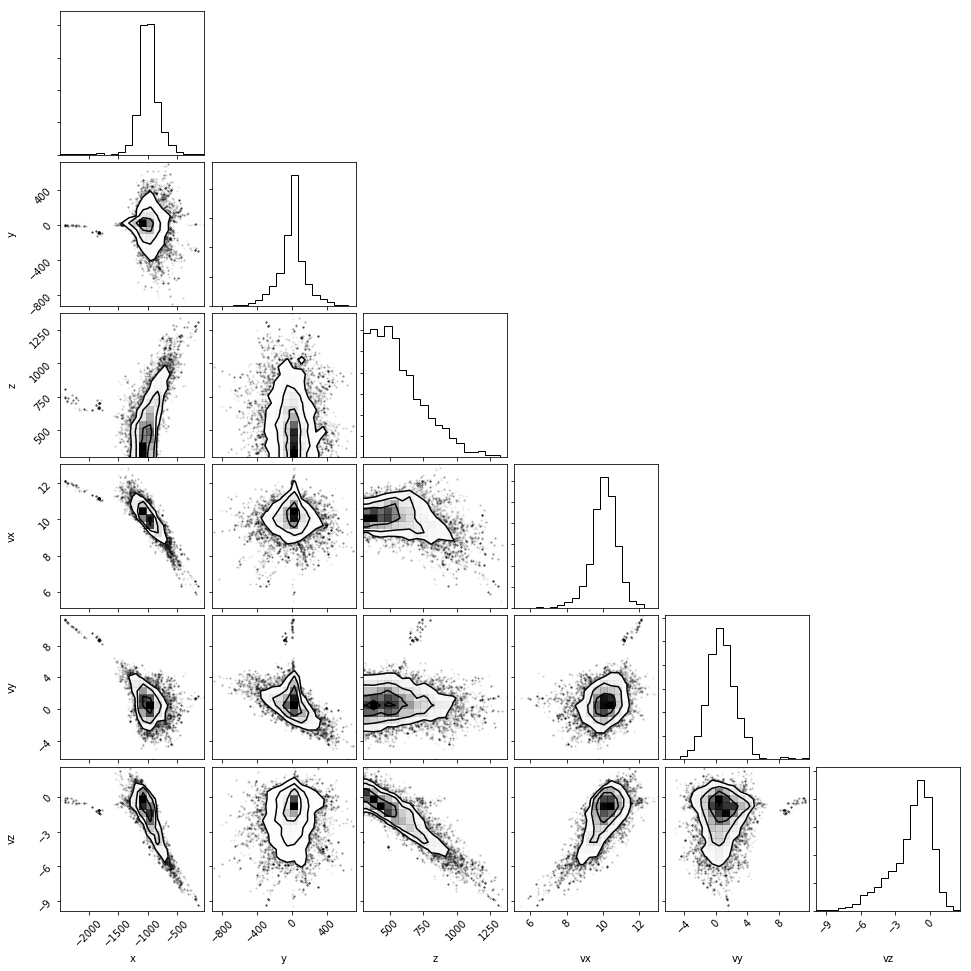

In [17]:
fig = corner.corner(samples, labels=["x", "y", "z", "vx", "vy", "vz"])

(array([   75.,    41.,   134.,    15.,   714., 10427., 11334.,  2002.,
          199.,    59.]),
 array([-2478.8740709 , -2234.64007525, -1990.4060796 , -1746.17208395,
        -1501.93808831, -1257.70409266, -1013.47009701,  -769.23610136,
         -525.00210571,  -280.76811007,   -36.53411442]),
 <a list of 10 Patch objects>)

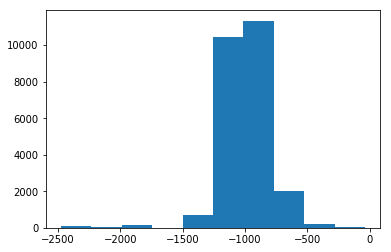

In [18]:
hist(samples[:,0])

(array([   14.,    81.,   263.,  1231.,  3564., 13763.,  4548.,  1194.,
          306.,    36.]),
 array([-920.9625081 , -756.66505434, -592.36760058, -428.07014682,
        -263.77269306,  -99.4752393 ,   64.82221446,  229.11966822,
         393.41712197,  557.71457573,  722.01202949]),
 <a list of 10 Patch objects>)

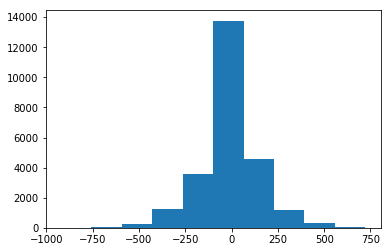

In [19]:
hist(samples[:,1])

(array([5967., 5959., 4884., 3311., 2163., 1444.,  775.,  253.,  187.,
          57.]),
 array([ 300.27184565,  407.7576611 ,  515.24347655,  622.729292  ,
         730.21510745,  837.7009229 ,  945.18673835, 1052.6725538 ,
        1160.15836925, 1267.6441847 , 1375.13000015]),
 <a list of 10 Patch objects>)

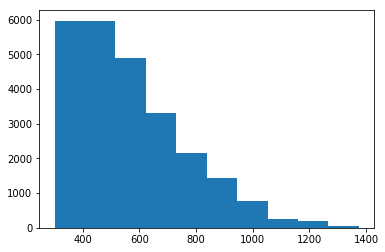

In [20]:
hist(samples[:,2])
